In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import openpyxl
import matplotlib
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from creme import preprocessing

from ts_utils import SARIMA_ONS, mape, rmse, mae

In [2]:
SEED = 42 # random seed
PERIOD = 7 # seasonality

In [3]:
def evaluate_model(series, p=2, P=4, D=0, s=PERIOD):
    # log transform
    series = np.log(series)
    
    # train test split
    train, val, test = np.split(series, [len(series) - s*8, len(series) - s*4])
    
    # stationary test (determine difference order d)
    significance_level = 0.05
    p_value = adfuller(train)[1]
    if p_value < significance_level:
        d = 0
    else:
        d = 1
        
    model = SARIMA_ONS([], order=p, order_s=P, diff=d, diff_s=D, period=s)
    
    scaler = preprocessing.StandardScaler()
    X_pred = []
    for x in series:
        # normalize
        x = {'x': x}
        x_normalized = scaler.fit_one(x).transform_one(x)['x']

        # fit model
        x_pred_normalized, loss = model.fit_one_step(x_normalized)

        # inverse transform
        current_std = scaler.variances['x'].get() ** 0.5
        current_mean = scaler.variances['x'].mean.get()
        x_pred = x_pred_normalized * current_std + current_mean

        X_pred.append(x_pred)
    forecast = pd.Series(X_pred[-len(test):], index=test.index)
    
    # reverse log transform
    test = np.exp(test)
    forecast = np.exp(forecast)
    
    print('model: ({}, {}, {})x({}, {}, {})_{}'.format(p, d, 0, P, D, 0, PERIOD))
    print('MAPE: {}'.format(mape(test, forecast)))
    print('RMSE: {}'.format(rmse(test, forecast)))
    print('MAE: {}'.format(mae(test, forecast)))
    return forecast

In [4]:
wb = openpyxl.load_workbook("data/australia_electricity_load.xlsx")

rows_data = []
for r in wb['Sheet1'].rows:
    if r[0].value is None:
        row_data = [c.value for c in r[1:-1]]
    else:
        row_data = [c.value for c in r[:-2]]
    rows_data.append(row_data)
    
df = pd.DataFrame(rows_data[:-1], columns=["Weekday", "Month", "Day", "Year", "Time", "AM/PM", "Load"])
series = pd.Series(df['Load'].values, index=df['Load'].index)

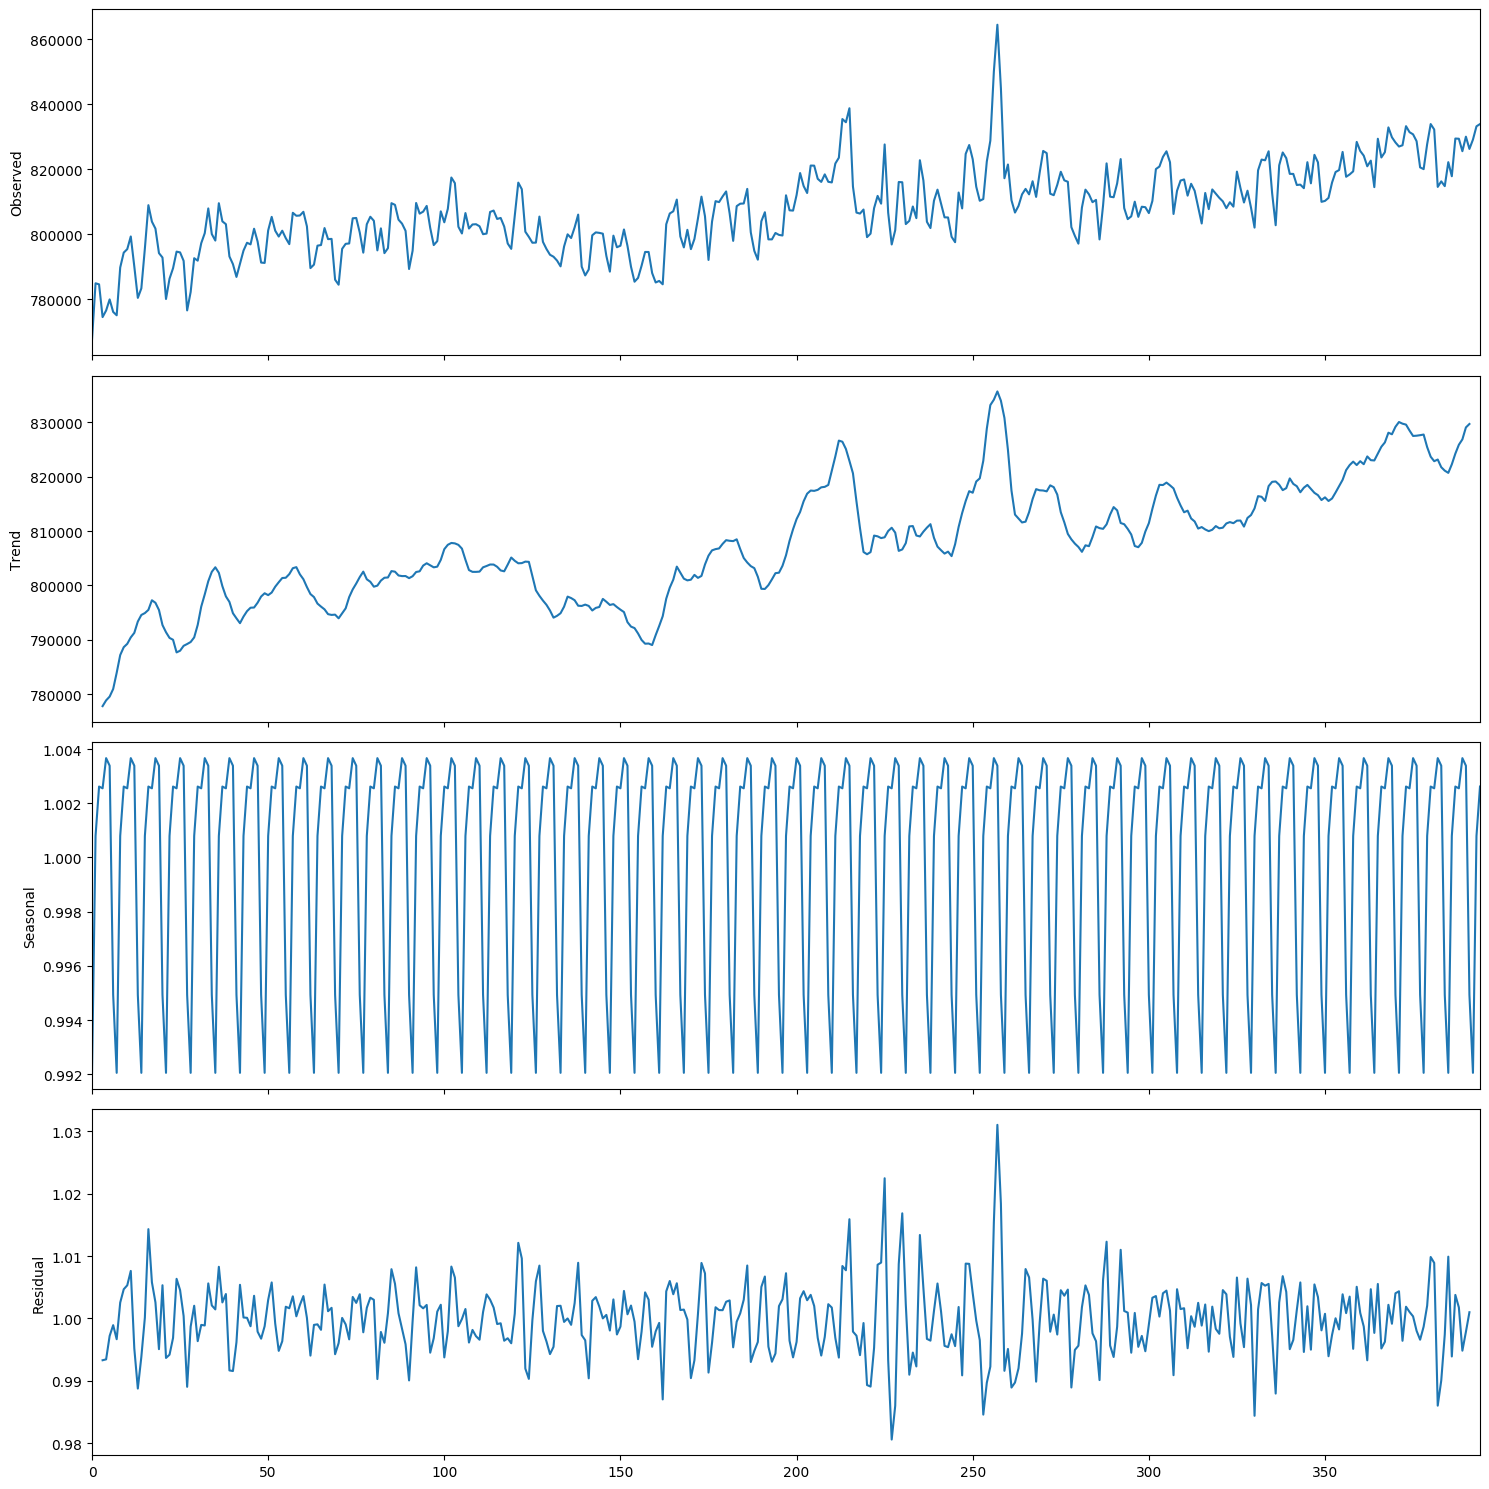

In [5]:
decomposed_series = seasonal_decompose(series, model='multiplicative', freq=PERIOD)
with matplotlib.rc_context():
    matplotlib.rc("figure", figsize=(15, 15))
    decomposed_series.plot()
    plt.show()

In [6]:
forecast = evaluate_model(series, p=1, P=2, D=0, s=PERIOD)
# forecast = evaluate_model(series, p=1, P=3, D=1, s=PERIOD)

model: (1, 1, 0)x(2, 0, 0)_7
MAPE: 0.004418314532191565
RMSE: 5435.075703976154
MAE: 3647.412634315202


In [7]:
def plot_ts(x, y=None, title='Australia Electricity Load', xlabel='Time', ylabel='#Passengers', save=False, name='prediction.png'):
    plt.figure(figsize=(14, 5))
    plt.plot(x, 'b', label='Actual time series')
    if y is not None:
        plt.plot(y, 'r', label='Forecast')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc="upper left")
    if save:
        plt.savefig(name)
    else:
        plt.show()

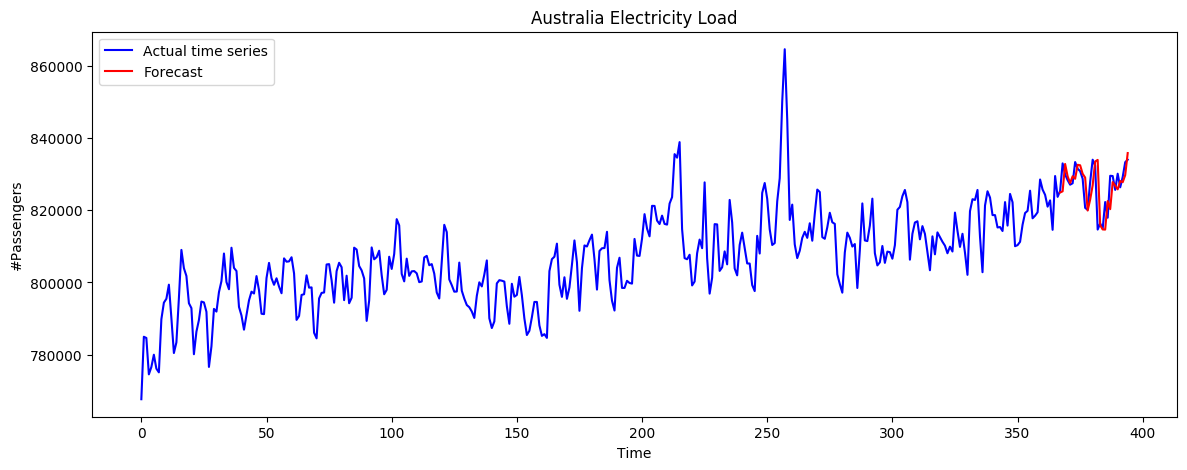

In [8]:
plot_ts(series, forecast, save=False)

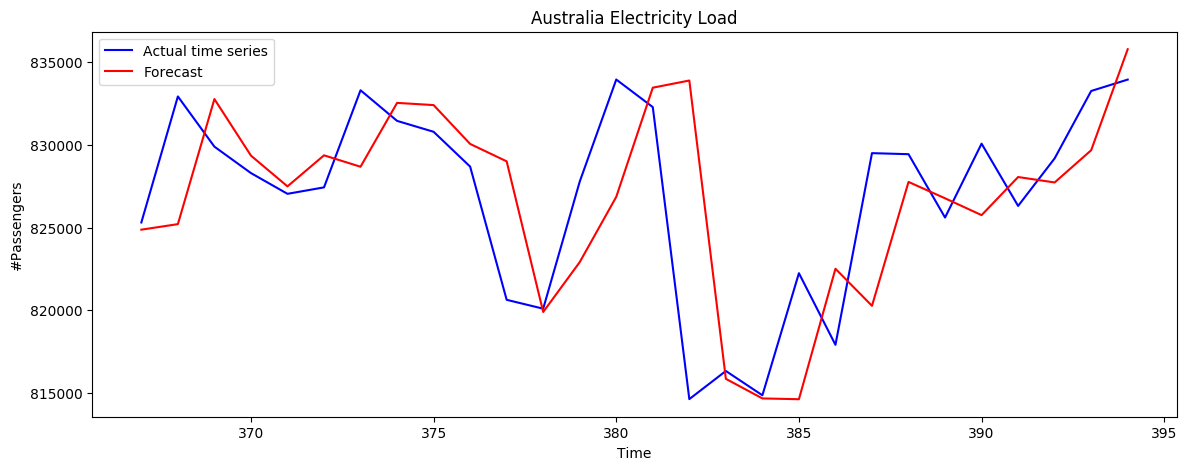

In [9]:
plot_ts(series[-len(forecast):], forecast, save=False)